In [0]:
!pip install tf-nightly

In [0]:
import tensorflow_datasets as tfds
import tensorflow as tf

import time
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
import re
import numpy as np
from tqdm import tqdm, tqdm_notebook
from html.parser import HTMLParser
import pickle
from nltk.translate.bleu_score import corpus_bleu

In [5]:
data_folder = os.path.join(os.getcwd(), 'data')
data_files = [os.path.join(data_folder, file_name) for file_name in os.listdir(data_folder)]
data_files

['/content/drive/My Drive/Cinnamon/a8/data/train.en',
 '/content/drive/My Drive/Cinnamon/a8/data/train.vi',
 '/content/drive/My Drive/Cinnamon/a8/data/tst2012.vi',
 '/content/drive/My Drive/Cinnamon/a8/data/tst2012.en',
 '/content/drive/My Drive/Cinnamon/a8/data/tst2013.en',
 '/content/drive/My Drive/Cinnamon/a8/data/tst2013.vi',
 '/content/drive/My Drive/Cinnamon/a8/data/dict.en-vi',
 '/content/drive/My Drive/Cinnamon/a8/data/vocab.en',
 '/content/drive/My Drive/Cinnamon/a8/data/vocab.vi']

In [0]:
class MLStripper(HTMLParser):
    def __init__(self):
        self.reset()
        self.strict = False
        self.convert_charrefs= True
        self.fed = []
    def handle_data(self, d):
        self.fed.append(d)
    def get_data(self):
        return ''.join(self.fed)

def strip_tags(html):
    s = MLStripper()
    s.feed(html)
    return s.get_data()

In [0]:
def load_text(file_name, data_foder='./data'):
    
    data_path = os.path.join(data_folder, file_name)
    with open(data_path, 'r') as f:
        texts = f.read().split('\n')
        texts = map(strip_tags, texts)
        texts = [' '.join(re.findall(r"[\w'.?!,]+", w.lower())) for w in texts]
    
    return texts

In [0]:
en_train, vi_train, en_val, vi_val, en_test, vi_test = map(load_text,['train.en', 'train.vi', 'tst2013.en', 'tst2013.vi', 'tst2012.en', 'tst2012.vi'])

In [0]:
en_train_formatted = tf.data.Dataset.from_tensor_slices(en_train)
vi_train_formatted = tf.data.Dataset.from_tensor_slices(vi_train)

en_val_formatted = tf.data.Dataset.from_tensor_slices(en_val)
vi_val_formatted = tf.data.Dataset.from_tensor_slices(vi_val)

In [0]:
train_examples = tf.data.Dataset.zip((en_train_formatted, vi_train_formatted))
val_examples = tf.data.Dataset.zip((en_val_formatted, vi_val_formatted))

In [0]:
#tokenizer_en = tfds.features.text.SubwordTextEncoder.build_from_corpus(
#    (en.numpy() for en, vi in train_examples), target_vocab_size=2**13)

#tokenizer_vi = tfds.features.text.SubwordTextEncoder.build_from_corpus(
#    (vi.numpy() for en, vi in train_examples), target_vocab_size=2**13)

#pickle.dump(tokenizer_en, open('./subword_text_encoder/en.pkl', 'wb'))
#pickle.dump(tokenizer_vi, open('./subword_text_encoder/vi.pkl', 'wb'))

tokenizer_en = pickle.load(open('./subword_text_encoder/en.pkl', 'rb'))
tokenizer_vi = pickle.load(open('./subword_text_encoder/vi.pkl', 'rb'))

In [0]:
def encode(lang1, lang2):
  lang1 = [tokenizer_en.vocab_size] + tokenizer_en.encode(
      lang1.numpy()) + [tokenizer_en.vocab_size+1]

  lang2 = [tokenizer_vi.vocab_size] + tokenizer_vi.encode(
      lang2.numpy()) + [tokenizer_vi.vocab_size+1]
  
  return lang1, lang2

In [0]:
def tf_encode(en, vi):
  result_en, result_vi = tf.py_function(encode, [en, vi], [tf.int64, tf.int64])
  result_en.set_shape([None])
  result_vi.set_shape([None])

  return result_en, result_vi

In [0]:
MAX_LENGTH = 40

def filter_max_length(x, y, max_length=MAX_LENGTH):
  return tf.logical_and(tf.size(x) <= max_length,
                        tf.size(y) <= max_length)

In [0]:
BUFFER_SIZE = len(en_train)
BATCH_SIZE = 64

train_dataset = train_examples.map(tf_encode)
train_dataset = train_dataset.filter(filter_max_length)
# cache the dataset to memory to get a speedup while reading from it.
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(BUFFER_SIZE).padded_batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

val_dataset = val_examples.map(tf_encode)
val_dataset = val_dataset.filter(filter_max_length).padded_batch(BATCH_SIZE)

In [0]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
  
  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
  pos_encoding = angle_rads[np.newaxis, ...]
    
  return tf.cast(pos_encoding, dtype=tf.float32)

In [0]:
# pos_encoding = positional_encoding(50, 512)

In [0]:
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  
  # add extra dimensions to add the padding
  # to the attention logits.
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)  

In [0]:
def scaled_dot_product_attention(q, k, v, mask):
  """Calculate the attention weights.
  q, k, v must have matching leading dimensions.
  k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
  The mask has different shapes depending on its type(padding or look ahead) 
  but it must be broadcastable for addition.
  
  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable 
          to (..., seq_len_q, seq_len_k). Defaults to None.
    
  Returns:
    output, attention_weights
  """

  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
  
  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)  

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

In [0]:
def print_out(q, k, v):
  temp_out, temp_attn = scaled_dot_product_attention(
      q, k, v, None)
  print ('Attention weights are:')
  print (temp_attn)
  print ('Output is:')
  print (temp_out)

np.set_printoptions(suppress=True)

In [0]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model
    
    assert d_model % self.num_heads == 0
    
    self.depth = d_model // self.num_heads
    
    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)
    
    self.dense = tf.keras.layers.Dense(d_model)
        
  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])
    
  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]
    
    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)
    
    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)
    
    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)
    
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention, 
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
        
    return output, attention_weights

In [0]:
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

In [0]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    
  def call(self, x, training, mask):

    attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)
    
    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)
    
    return out2

In [0]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = MultiHeadAttention(d_model, num_heads)
    self.mha2 = MultiHeadAttention(d_model, num_heads)

    self.ffn = point_wise_feed_forward_network(d_model, dff)
 
    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
  def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):
    # enc_output.shape == (batch_size, input_seq_len, d_model)

    attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(attn1 + x)
    
    attn2, attn_weights_block2 = self.mha2(
        enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)
    
    ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)
    
    return out3, attn_weights_block1, attn_weights_block2

In [0]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, 
                                            self.d_model)
    
    
    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
  
    self.dropout = tf.keras.layers.Dropout(rate)
        
  def call(self, x, training, mask):

    seq_len = tf.shape(x)[1]
    
    # adding embedding and position encoding.
    x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)
    
    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask)
    
    return x  # (batch_size, input_seq_len, d_model)

In [0]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)
    
    self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)
    
  def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):

    seq_len = tf.shape(x)[1]
    attention_weights = {}
    
    x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]
    
    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                             look_ahead_mask, padding_mask)
      
      attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
      attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
    
    # x.shape == (batch_size, target_seq_len, d_model)
    return x, attention_weights

In [0]:
class Transformer(tf.keras.Model):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
               target_vocab_size, pe_input, pe_target, rate=0.1):
    super(Transformer, self).__init__()

    self.encoder = Encoder(num_layers, d_model, num_heads, dff, 
                           input_vocab_size, pe_input, rate)

    self.decoder = Decoder(num_layers, d_model, num_heads, dff, 
                           target_vocab_size, pe_target, rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
  def call(self, inp, tar, training, enc_padding_mask, 
           look_ahead_mask, dec_padding_mask):

    enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)
    
    # dec_output.shape == (batch_size, tar_seq_len, d_model)
    dec_output, attention_weights = self.decoder(
        tar, enc_output, training, look_ahead_mask, dec_padding_mask)
    
    final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)
    
    return final_output, attention_weights

In [0]:
num_layers = 6
d_model = 512 
dff = 2048
num_heads = 8

input_vocab_size = tokenizer_en.vocab_size + 2
target_vocab_size = tokenizer_vi.vocab_size + 2
dropout_rate = 0.1

transformer = Transformer(num_layers, d_model, num_heads, dff,
                          input_vocab_size, target_vocab_size, 
                          pe_input=input_vocab_size, 
                          pe_target=target_vocab_size,
                          rate=dropout_rate)

In [0]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps
    
  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    
    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask
  
  return tf.reduce_mean(loss_)

train_loss = tf.keras.metrics.Mean(name='train_loss')

train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')  

In [0]:
def create_masks(inp, tar):
  # Encoder padding mask
  enc_padding_mask = create_padding_mask(inp)
  
  # Used in the 2nd attention block in the decoder.
  # This padding mask is used to mask the encoder outputs.
  dec_padding_mask = create_padding_mask(inp)
  
  # Used in the 1st attention block in the decoder.
  # It is used to pad and mask future tokens in the input received by 
  # the decoder.
  look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
  dec_target_padding_mask = create_padding_mask(tar)
  combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  
  return enc_padding_mask, combined_mask, dec_padding_mask

In [0]:
checkpoint_path = "./checkpoints/"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

In [0]:
train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]
  
  enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
  
  with tf.GradientTape() as tape:
    predictions, _ = transformer(inp, tar_inp, 
                                 True, 
                                 enc_padding_mask, 
                                 combined_mask, 
                                 dec_padding_mask)
    loss = loss_function(tar_real, predictions)

  gradients = tape.gradient(loss, transformer.trainable_variables)    
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
  
  train_loss(loss)
  train_accuracy(tar_real, predictions)

In [33]:
%%time
EPOCHS = 10

accuracy = pd.DataFrame()
loss = pd.DataFrame()

for att in ['num_layers', 'd_model', 'dff', 'num_heads']:
    accuracy[att] = [eval(att)]
    loss[att] = [eval(att)]

for epoch in tqdm_notebook(range(EPOCHS)):
  
  train_loss.reset_states()
  train_accuracy.reset_states()
  
  # inp -> portuguese, tar -> english
  for (batch, (inp, tar)) in enumerate(train_dataset):
    train_step(inp, tar)
        
  ckpt_save_path = ckpt_manager.save()
  print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))
    
  print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, 
                                                train_loss.result(), 
                                                train_accuracy.result()))
  
  accuracy[f'Epoch {epoch + 1}'] = [train_accuracy.result()]
  loss[f'Epoch {epoch + 1}'] = [train_loss.result()]


Saving checkpoint for epoch 1 at ./checkpoints/ckpt-1
Epoch 1 Loss 2.8291 Accuracy 0.1007
Saving checkpoint for epoch 2 at ./checkpoints/ckpt-2
Epoch 2 Loss 2.0805 Accuracy 0.1602
Saving checkpoint for epoch 3 at ./checkpoints/ckpt-3
Epoch 3 Loss 1.9283 Accuracy 0.1709
Saving checkpoint for epoch 4 at ./checkpoints/ckpt-4
Epoch 4 Loss 1.8031 Accuracy 0.1826
Saving checkpoint for epoch 5 at ./checkpoints/ckpt-5
Epoch 5 Loss 1.7130 Accuracy 0.1913
Saving checkpoint for epoch 6 at ./checkpoints/ckpt-6
Epoch 6 Loss 1.6433 Accuracy 0.1981
Saving checkpoint for epoch 7 at ./checkpoints/ckpt-7
Epoch 7 Loss 1.5896 Accuracy 0.2041
Saving checkpoint for epoch 8 at ./checkpoints/ckpt-8
Epoch 8 Loss 1.5412 Accuracy 0.2093
Saving checkpoint for epoch 9 at ./checkpoints/ckpt-9
Epoch 9 Loss 1.5004 Accuracy 0.2140
Saving checkpoint for epoch 10 at ./checkpoints/ckpt-10
Epoch 10 Loss 1.4635 Accuracy 0.2183

CPU times: user 1h 9min 10s, sys: 16min 57s, total: 1h 26min 8s
Wall time: 2h 23s


In [0]:
def evaluate(inp_sentence):
  inp_sentence = ' '.join(re.findall(r"[\w'.?!,]+", inp_sentence.lower()))
  start_token = [tokenizer_en.vocab_size]
  end_token = [tokenizer_en.vocab_size + 1]
  
  # inp sentence is portuguese, hence adding the start and end token
  inp_sentence = start_token + tokenizer_en.encode(inp_sentence) + end_token
  encoder_input = tf.expand_dims(inp_sentence, 0)
  
  # as the target is english, the first word to the transformer should be the
  # english start token.
  decoder_input = [tokenizer_vi.vocab_size]
  output = tf.expand_dims(decoder_input, 0)
    
  for i in range(MAX_LENGTH):
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
        encoder_input, output)
  
    # predictions.shape == (batch_size, seq_len, vocab_size)
    predictions, attention_weights = transformer(encoder_input, 
                                                 output,
                                                 False,
                                                 enc_padding_mask,
                                                 combined_mask,
                                                 dec_padding_mask)
    
    # select the last word from the seq_len dimension
    predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)

    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
    
    # return the result if the predicted_id is equal to the end token
    if predicted_id == tokenizer_vi.vocab_size+1:
      return tf.squeeze(output, axis=0), attention_weights
    
    # concatentate the predicted_id to the output which is given to the decoder
    # as its input.
    output = tf.concat([output, predicted_id], axis=-1)

  return tf.squeeze(output, axis=0), attention_weights

In [0]:
def translate(sentence):
  result, attention_weights = evaluate(sentence)
  predicted_sentence = tokenizer_vi.decode([i for i in result 
                                            if i < tokenizer_en.vocab_size])  

  return predicted_sentence

In [36]:
references = []
candidates = []
for i in tqdm_notebook(range(len(en_test))):
  if len(en_test[i])<MAX_LENGTH:
      references.append([en_test[i]])
      candidates.append(translate(vi_test[i]))

score = corpus_bleu(references, candidates)
accuracy['BLEU'] = [score]

In [0]:
loss.to_csv('loss0.csv')
accuracy.to_csv('accuracy0.csv')

In [0]:
loss0 = pd.read_csv('loss0.csv', index_col=0)
loss1 = pd.read_csv('loss1.csv', index_col=0)
loss2 = pd.read_csv('loss2.csv', index_col=0)
loss3 = pd.read_csv('loss3.csv', index_col=0)

acc0 = pd.read_csv('accuracy0.csv', index_col=0)
acc1 = pd.read_csv('accuracy1.csv', index_col=0)
acc2 = pd.read_csv('accuracy2.csv', index_col=0)
acc3 = pd.read_csv('accuracy3.csv', index_col=0)

In [0]:
loss = pd.concat([loss0, loss1, loss2, loss3])
acc = pd.concat([acc0, acc1, acc2, acc3])

In [0]:
loss.to_csv('loss.csv', index=False)
acc.to_csv('acc.csv', index=False)

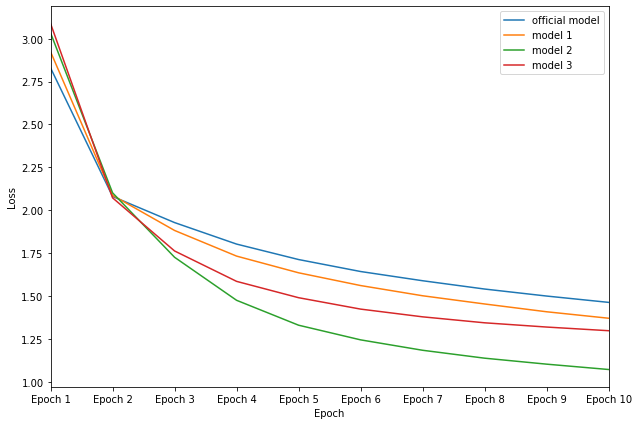

In [102]:
plt.figure(figsize=(10,7))
features = [f'Epoch {i+1}' for i in range(10)]

loss.iloc[0][features].plot()
loss.iloc[1][features].plot()
loss.iloc[2][features].plot()
loss.iloc[3][features].plot()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['official model','model 1', 'model 2', 'model 3'])
plt.savefig('loss.png')

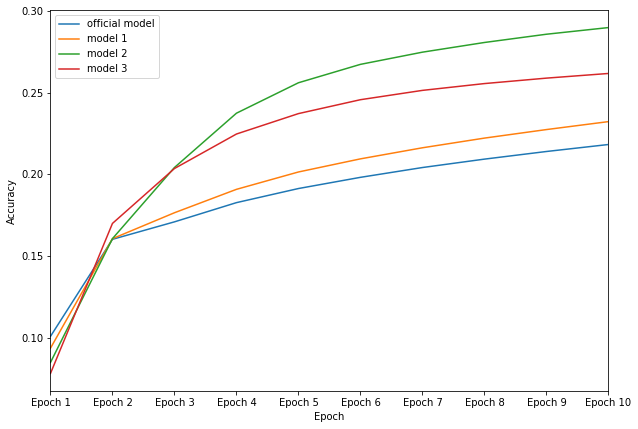

In [103]:
plt.figure(figsize=(10,7))

acc.iloc[0][features].plot()
acc.iloc[1][features].plot()
acc.iloc[2][features].plot()
acc.iloc[3][features].plot()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['official model','model 1', 'model 2', 'model 3'])
plt.savefig('acc.png')